## **Health Care & Personal Dataset**

## **LSTM**

In [1]:
!pip install pandas numpy matplotlib seaborn nltk textblob wordcloud scikit-learn


## **Loading the Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

/usr/local/lib/python3.10/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
meta_data = pd.read_csv("/kaggle/input/amazon32/amazon_metadata_health_personal_care.csv")
reviews = pd.read_csv("/kaggle/input/amazon32/amazon_reviews_health_personal_care.csv")

# Display first few rows
print("Metadata Dataset:")
display(meta_data.head())

print("\nReviews Dataset:")
display(reviews.head())


Metadata Dataset:


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,main_category,title,average_rating,rating_number,price,store,parent_asin,date_first_available
0,Health & Personal Care,Silicone Bath Body Brush Exfoliator Shower Bac...,3.9,7,NaN,Rzoeox,B07V346GZH,"January 10, 2021"
1,Health & Personal Care,"iPhone 7 Plus 8 Plus Screen Protector, ZHXIN T...",3.8,2,NaN,ZHXIN,B075W927RH,"September 24, 2017"
2,Health & Personal Care,Zig Zag Rolling Machine 70mm Size With FREE BO...,3.9,7,NaN,NaN,B01FB26VKY,"May 27, 2016"
3,Health & Personal Care,Sting-Kill Disposable Wipes 8 Each ( Pack of 5),4.1,6,21.37,Sting-kill,B01IAI29RU,"July 11, 2016"
4,Health & Personal Care,Heated Eyelash Curler Mini Portable Electric E...,3.3,8,NaN,BiBOSS,B08CMN38RC,"July 24, 2020"



Reviews Dataset:


,rating,title,text,helpful_vote,parent_asin,verified_purchase,review_date
0,4.0,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,3,B07TDSJZMR,True,2020-02-06
1,5.0,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,3,B08637FWWF,True,2020-11-02
2,5.0,Fantastic,I have been suffering a couple months with hee...,0,B07KJVGNN5,True,2019-07-24
3,4.0,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",7,B092RP73CX,True,2022-09-04
4,1.0,Not for me,Didn't do a thing for me. Not saying they don'...,0,B08KYJLF5T,True,2022-01-20


## **Data Preprocessing**

In [4]:
# Convert review_date with error handling
reviews["review_date"] = pd.to_datetime(reviews["review_date"], errors='coerce', infer_datetime_format=True)

# Convert date_first_available with error handling
meta_data["date_first_available"] = pd.to_datetime(meta_data["date_first_available"], errors='coerce', infer_datetime_format=True)

# Identify rows with conversion issues
print("Invalid dates in reviews:", reviews["review_date"].isna().sum())
print("Invalid dates in meta_data:", meta_data["date_first_available"].isna().sum())

# Optionally drop rows with NaT values after conversion
reviews.dropna(subset=["review_date"], inplace=True)
meta_data.dropna(subset=["date_first_available"], inplace=True)

# Merge datasets
merged_df = reviews.merge(meta_data, on="parent_asin", how="left")

print("Merged Data Preview:")
display(merged_df.head())


<ipython-input-4-6419238e334a>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  reviews["review_date"] = pd.to_datetime(reviews["review_date"], errors='coerce', infer_datetime_format=True)
<ipython-input-4-6419238e334a>:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  meta_data["date_first_available"] = pd.to_datetime(meta_data["date_first_available"], errors='coerce', infer_datetime_format=True)


Invalid dates in reviews: 0
Invalid dates in meta_data: 2306
Merged Data Preview:


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,rating,title_x,text,helpful_vote,parent_asin,verified_purchase,review_date,main_category,title_y,average_rating,rating_number,price,store,date_first_available
0,4.0,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,3,B07TDSJZMR,True,2020-02-06,Health & Personal Care,High Potency Magnesium Citrate Capsules 1000mg...,4.5,470.0,NaN,Life Nutrition,2019-08-11
1,5.0,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,3,B08637FWWF,True,2020-11-02,Health & Personal Care,Evolve Concentrated Bleach Tablets - 32-ct Bot...,4.8,181.0,NaN,Evolve,2019-09-12
2,5.0,Fantastic,I have been suffering a couple months with hee...,0,B07KJVGNN5,True,2019-07-24,Health & Personal Care,"Dr. Foot's Gel Heel Protectors, Plantar Fascii...",3.6,78.0,NaN,Dr.Foot,2018-11-15
3,4.0,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",7,B092RP73CX,True,2022-09-04,Health & Personal Care,"Homedics Bubble Bliss Deluxe-Foot Spa, Heat Ma...",4.4,8312.0,NaN,Homedics,2019-09-17
4,1.0,Not for me,Didn't do a thing for me. Not saying they don'...,0,B08KYJLF5T,True,2022-01-20,Health & Personal Care,Brain Supplement 1053mg - Premium Nootropic Br...,4.1,94.0,NaN,Nature's Nutrition,2020-12-08


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [6]:
# Ensure missing text is filled
reviews["text"] = reviews["text"].fillna("")

# Convert rating into sentiment labels (3+ = positive, else negative)
reviews["label"] = reviews["rating"].apply(lambda x: 1 if x >= 3 else 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(reviews["text"], reviews["label"], test_size=0.2, random_state=42)

## **Tokenization**

In [7]:
#%%
# Tokenization
max_words = 10000  # Vocabulary size
max_len = 200  # Max length of sequences

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
#%%
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
#%%
# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")
#%%
# Convert labels to NumPy arrays
y_train, y_test = np.array(y_train), np.array(y_test)
#%%
# Build LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## **Training**

In [8]:
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

# 🔹 🔟 Train Model
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                    epochs=5, batch_size=32, callbacks=[early_stop])

Epoch 1/5
12353/12353 ━━━━━━━━━━━━━━━━━━━━ 190s 15ms/step - accuracy: 0.8016 - loss: 0.5014 - val_accuracy: 0.7986 - val_loss: 0.5053
Epoch 2/5
12353/12353 ━━━━━━━━━━━━━━━━━━━━ 183s 15ms/step - accuracy: 0.8011 - loss: 0.4990 - val_accuracy: 0.7986 - val_loss: 0.5033
Epoch 3/5
12353/12353 ━━━━━━━━━━━━━━━━━━━━ 183s 15ms/step - accuracy: 0.8240 - loss: 0.4318 - val_accuracy: 0.9168 - val_loss: 0.1992
Epoch 4/5
12353/12353 ━━━━━━━━━━━━━━━━━━━━ 183s 15ms/step - accuracy: 0.9216 - loss: 0.1880 - val_accuracy: 0.9235 - val_loss: 0.1815
Epoch 5/5
12353/12353 ━━━━━━━━━━━━━━━━━━━━ 183s 15ms/step - accuracy: 0.9337 - loss: 0.1608 - val_accuracy: 0.9245 - val_loss: 0.1791


In [9]:
# 🔹 1️⃣1️⃣ Evaluate Model
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.4f}")

3089/3089 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9251 - loss: 0.1783
Test Accuracy: 0.9245


## **Model Evaluation**

In [10]:
from sklearn.metrics import classification_report


# 🔹 1️⃣2️⃣ Generate Predictions for Classification Report
y_pred_prob = model.predict(X_test_pad)  # Get probability scores
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary labels (0 or 1)

# 🔹 1️⃣3️⃣ Print Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

3089/3089 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step

Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      0.78      0.81     19904
    Positive       0.95      0.96      0.95     78921

    accuracy                           0.92     98825
   macro avg       0.89      0.87      0.88     98825
weighted avg       0.92      0.92      0.92     98825



In [11]:
# 🔹 1️⃣1️⃣ Save the trained model
model.save("sentiment_lstm.h5")
print("Model saved successfully!")

Model saved successfully!


In [10]:
!pip install torch torchtext


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.6 MB/s eta 0:00:00a 0:00:01


## **Exploratory Data Analysis**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [3]:
meta_data = pd.read_csv("/kaggle/input/amazon32/amazon_metadata_health_personal_care.csv")
reviews = pd.read_csv("/kaggle/input/amazon32/amazon_reviews_health_personal_care.csv")

# Display first few rows
print("Metadata Dataset:")
display(meta_data.head())

print("\nReviews Dataset:")
display(reviews.head())


Metadata Dataset:


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,main_category,title,average_rating,rating_number,price,store,parent_asin,date_first_available
0,Health & Personal Care,Silicone Bath Body Brush Exfoliator Shower Bac...,3.9,7,NaN,Rzoeox,B07V346GZH,"January 10, 2021"
1,Health & Personal Care,"iPhone 7 Plus 8 Plus Screen Protector, ZHXIN T...",3.8,2,NaN,ZHXIN,B075W927RH,"September 24, 2017"
2,Health & Personal Care,Zig Zag Rolling Machine 70mm Size With FREE BO...,3.9,7,NaN,NaN,B01FB26VKY,"May 27, 2016"
3,Health & Personal Care,Sting-Kill Disposable Wipes 8 Each ( Pack of 5),4.1,6,21.37,Sting-kill,B01IAI29RU,"July 11, 2016"
4,Health & Personal Care,Heated Eyelash Curler Mini Portable Electric E...,3.3,8,NaN,BiBOSS,B08CMN38RC,"July 24, 2020"



Reviews Dataset:


,rating,title,text,helpful_vote,parent_asin,verified_purchase,review_date
0,4.0,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,3,B07TDSJZMR,True,2020-02-06
1,5.0,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,3,B08637FWWF,True,2020-11-02
2,5.0,Fantastic,I have been suffering a couple months with hee...,0,B07KJVGNN5,True,2019-07-24
3,4.0,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",7,B092RP73CX,True,2022-09-04
4,1.0,Not for me,Didn't do a thing for me. Not saying they don'...,0,B08KYJLF5T,True,2022-01-20


In [4]:
# Convert review_date with error handling
reviews["review_date"] = pd.to_datetime(reviews["review_date"], errors='coerce', infer_datetime_format=True)

# Convert date_first_available with error handling
meta_data["date_first_available"] = pd.to_datetime(meta_data["date_first_available"], errors='coerce', infer_datetime_format=True)

# Identify rows with conversion issues
print("Invalid dates in reviews:", reviews["review_date"].isna().sum())
print("Invalid dates in meta_data:", meta_data["date_first_available"].isna().sum())

# Optionally drop rows with NaT values after conversion
reviews.dropna(subset=["review_date"], inplace=True)
meta_data.dropna(subset=["date_first_available"], inplace=True)

# Merge datasets
merged_df = reviews.merge(meta_data, on="parent_asin", how="left")

print("Merged Data Preview:")
display(merged_df.head())


<ipython-input-4-6419238e334a>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  reviews["review_date"] = pd.to_datetime(reviews["review_date"], errors='coerce', infer_datetime_format=True)
<ipython-input-4-6419238e334a>:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  meta_data["date_first_available"] = pd.to_datetime(meta_data["date_first_available"], errors='coerce', infer_datetime_format=True)


Invalid dates in reviews: 0
Invalid dates in meta_data: 2306
Merged Data Preview:


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,rating,title_x,text,helpful_vote,parent_asin,verified_purchase,review_date,main_category,title_y,average_rating,rating_number,price,store,date_first_available
0,4.0,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,3,B07TDSJZMR,True,2020-02-06,Health & Personal Care,High Potency Magnesium Citrate Capsules 1000mg...,4.5,470.0,NaN,Life Nutrition,2019-08-11
1,5.0,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,3,B08637FWWF,True,2020-11-02,Health & Personal Care,Evolve Concentrated Bleach Tablets - 32-ct Bot...,4.8,181.0,NaN,Evolve,2019-09-12
2,5.0,Fantastic,I have been suffering a couple months with hee...,0,B07KJVGNN5,True,2019-07-24,Health & Personal Care,"Dr. Foot's Gel Heel Protectors, Plantar Fascii...",3.6,78.0,NaN,Dr.Foot,2018-11-15
3,4.0,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",7,B092RP73CX,True,2022-09-04,Health & Personal Care,"Homedics Bubble Bliss Deluxe-Foot Spa, Heat Ma...",4.4,8312.0,NaN,Homedics,2019-09-17
4,1.0,Not for me,Didn't do a thing for me. Not saying they don'...,0,B08KYJLF5T,True,2022-01-20,Health & Personal Care,Brain Supplement 1053mg - Premium Nootropic Br...,4.1,94.0,NaN,Nature's Nutrition,2020-12-08


Load the LSTM Model & Prepare Data

## **summary of Columns**

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np

# Load the trained LSTM model
model = tf.keras.models.load_model("/kaggle/input/lstm/tensorflow2/default/1/sentiment_lstm.h5")

# Load the datasets
meta_data = pd.read_csv("/kaggle/input/amazon32/amazon_metadata_health_personal_care.csv")
reviews = pd.read_csv("/kaggle/input/amazon32/amazon_reviews_health_personal_care.csv")

# Merge datasets
merged_df = reviews.merge(meta_data, on="parent_asin", how="left")

# Check the first few rows
print(merged_df.head())


   rating                                            title_x  \
0     4.0  12 mg is 12 on the periodic table people! Mg f...   
1     5.0                 Save the lanet using less plastic.   
2     5.0                                          Fantastic   
3     4.0  It holds the water and makes bubbles.  That's ...   
4     1.0                                         Not for me   

                                                text  helpful_vote  \
0  This review is more to clarify someone else’s ...             3   
1  Love these easy multitasking bleach tablets. B...             3   
2  I have been suffering a couple months with hee...             0   
3  It's cheap and it does what I wanted.  The "ma...             7   
4  Didn't do a thing for me. Not saying they don'...             0   

  parent_asin  verified_purchase review_date           main_category  \
0  B07TDSJZMR               True  2020-02-06  Health & Personal Care   
1  B08637FWWF               True  2020-11-02  Heal

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


## **Distribution of Ratings**

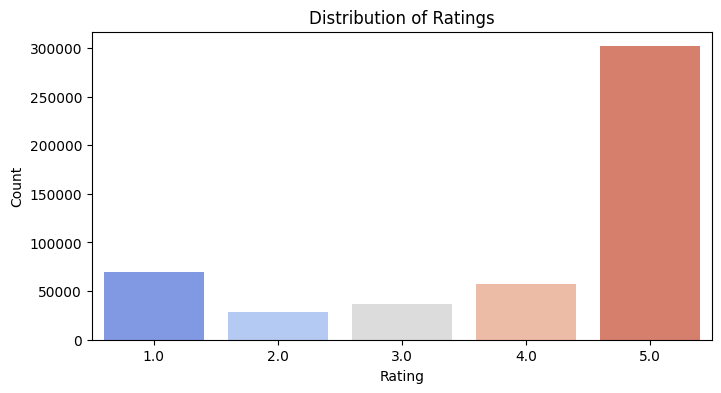

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(x=merged_df["rating"], palette="coolwarm", order=sorted(merged_df["rating"].unique()))
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


## **Word Cloud**

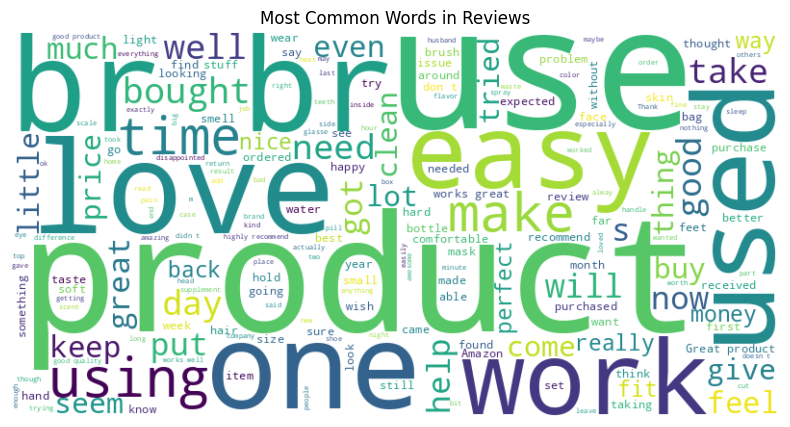

In [7]:
text = " ".join(merged_df["text"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Reviews")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load datasets
meta_data = pd.read_csv("/kaggle/input/amazon32/amazon_metadata_health_personal_care.csv")
reviews = pd.read_csv("/kaggle/input/amazon32/amazon_reviews_health_personal_care.csv")

# Merge datasets
merged_df = reviews.merge(meta_data, on="parent_asin", how="left")

# Display dataset info
print("Dataset Shape:", merged_df.shape)
print("\nMissing Values Summary:")
print(merged_df.isnull().sum())

# Display first few rows
display(merged_df.head())


In [11]:
# Summary of numerical columns
print("\nSummary Statistics of Numerical Columns:")
print(merged_df.describe())

# Unique categories in 'main_category'
print("\nUnique Categories:")
print(merged_df["main_category"].unique())

# Count of verified purchases
print("\nVerified vs Non-Verified Purchase Counts:")
print(merged_df["verified_purchase"].value_counts())



Summary Statistics of Numerical Columns:
              rating   helpful_vote  average_rating  rating_number  \
count  494121.000000  494121.000000   494121.000000  494121.000000   
mean        3.996523       1.131802        4.072002    1027.734073   
std         1.478626      15.437500        0.570980    3194.665289   
min         1.000000       0.000000        1.000000       1.000000   
25%         3.000000       0.000000        3.700000      32.000000   
50%         5.000000       0.000000        4.200000     139.000000   
75%         5.000000       1.000000        4.500000     621.000000   
max         5.000000    7326.000000        5.000000   60033.000000   

               price  
count  169019.000000  
mean       30.855426  
std        74.645572  
min         0.100000  
25%        12.500000  
50%        19.990000  
75%        33.990000  
max      4449.000000  

Unique Categories:
['Health & Personal Care']

Verified vs Non-Verified Purchase Counts:
verified_purchase
True     445

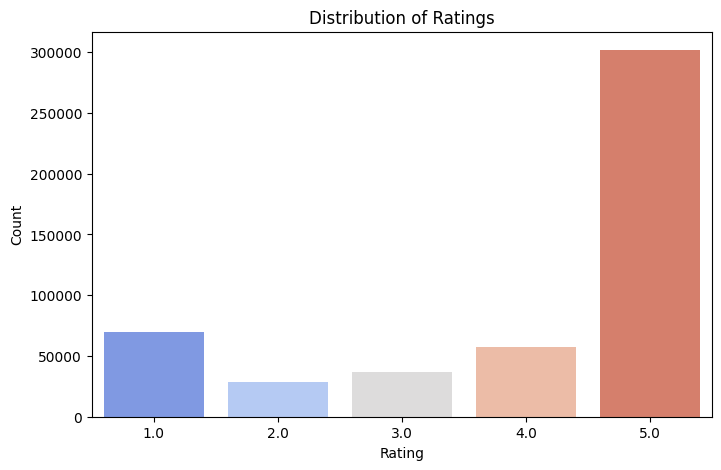

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(x="rating", data=merged_df, palette="coolwarm")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


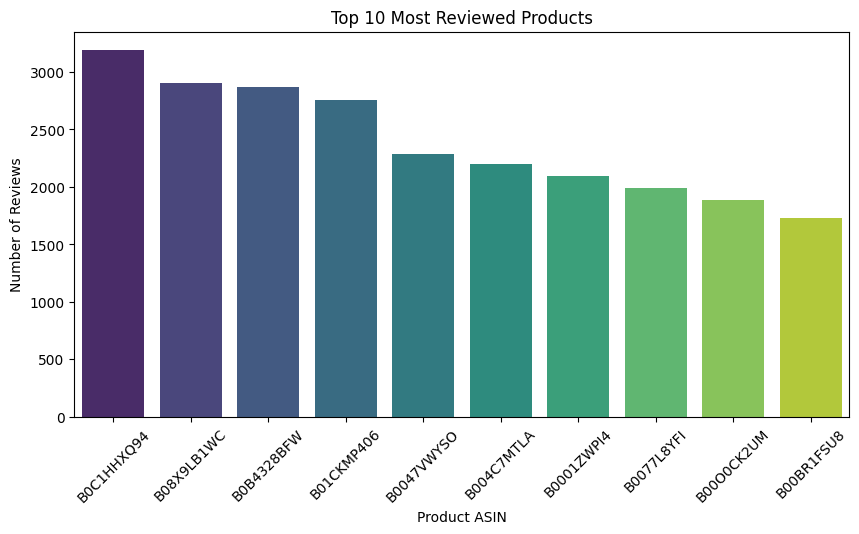

In [13]:
top_products = merged_df["parent_asin"].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_products.index, y=top_products.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Most Reviewed Products")
plt.xlabel("Product ASIN")
plt.ylabel("Number of Reviews")
plt.show()


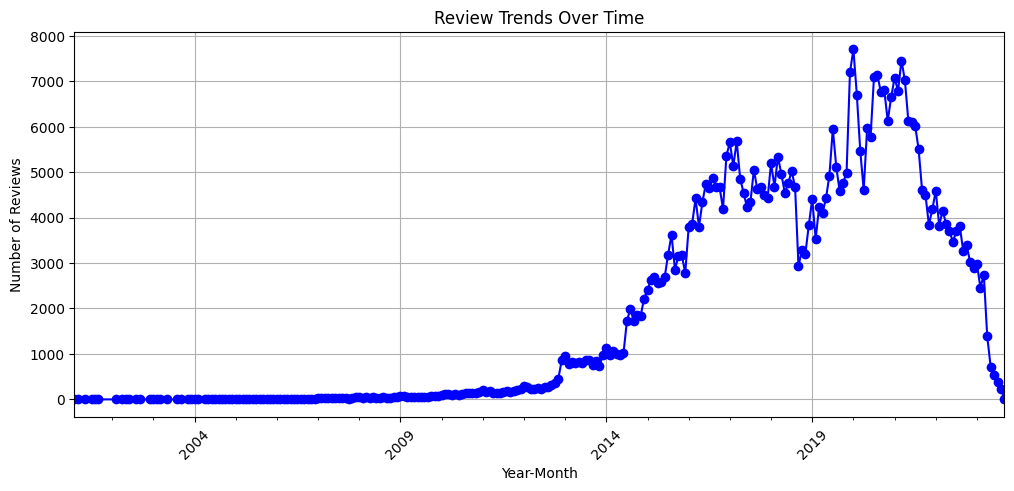

In [14]:
merged_df["review_date"] = pd.to_datetime(merged_df["review_date"])
merged_df["year_month"] = merged_df["review_date"].dt.to_period("M")

plt.figure(figsize=(12,5))
merged_df["year_month"].value_counts().sort_index().plot(kind="line", marker="o", color="b")
plt.title("Review Trends Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Load spaCy model for faster tokenization
nlp = spacy.load("en_core_web_sm")

# Function for optimized text processing
def preprocess_text_spacy(text):
    text = str(text).lower()
    doc = nlp(text)
    words = [token.text for token in doc if token.text.isalpha() and token.text not in stop_words]
    return words

# Sample 10,000 reviews for efficiency
sample_reviews = merged_df["text"].dropna().sample(n=10000, random_state=42)

# Apply faster processing
all_words = sample_reviews.apply(preprocess_text_spacy).sum()

# Get top 10 words
word_counts = Counter(all_words)
top_words = word_counts.most_common(10)

# Convert to DataFrame for plotting
top_words_df = pd.DataFrame(top_words, columns=["Word", "Count"])

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x="Word", y="Count", data=top_words_df, palette="viridis")
plt.title("Top 10 Most Frequent Words in Reviews (Sampled Data)")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()
